<a href="https://colab.research.google.com/github/EShepotinnik/meth_viz/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Шепотинник Егор
### группа М05-12Б

---
# Задание №2


In [184]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [206]:
! git clone https://github.com/EShepotinnik/meth_viz.git

Cloning into 'meth_viz'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [ ]:
Graph = nx.read_graphml('meth_viz/small_dag.graphml')

Посмотри как отрисовывается изначально граф

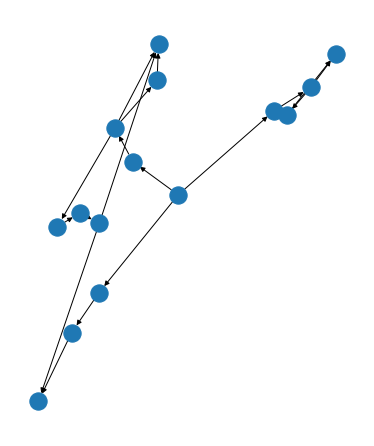

In [186]:
plt.figure(figsize=(5,6))
nx.draw(Graph)

Заданим функцию для подсчета пересечений

In [187]:
def inters(cords, left, right):
    count = 0
    for l_x in left:
        for r_x in right:
            if cords[l_x][0] > cords[r_x][0]:
                count += 1
    return count

In [188]:
def graph_layers_plus(cords):
    dic = {}

    for cord in cords:
        y_cord = cords[cord][1]
        if y_cord not in dic:
            dic[y_cord] = [cord]
        else:
            dic[y_cord].append(cord)

    return dic

def graph_layers_minus(cords):
    dic = {}

    for cord in cords:
        y_cord = -cords[cord][1]
        if y_cord not in dic:
            dic[y_cord] = [cord]
        else:
            dic[y_cord].append(cord)

    return dic

In [189]:
def up_down(G, sorted_gl, gl):
    up = {}
    down = {}

    neighbors = {}
    neighbors_inv = {} 

    for nodes in G.nodes:
        neighbors[nodes] = set()
        neighbors_inv[nodes] = set()

    for a, b in G.edges():
        neighbors_inv[b].add(a)
        neighbors[a].add(b)

    for y_cord, nodes in sorted_gl:
        if abs(y_cord) != len(gl):
            for i in nodes:
                up[i] = list(set(neighbors_inv[i])&(set(gl[y_cord - 1])))
                if y_cord != -1:
                    down[i] = list(set(neighbors[i])&(set(gl[y_cord + 1])))

    return up, down

In [190]:
def change(G, cords):
    dummies = set()
    for a, b in list(G.edges()):
        if abs(cords[b][1] - cords[a][1]) > 2:
            G.remove_edge(a, b)
            last_v = b
            for pos in range(cords[b][1] + 1, cords[a][1]):
                dn = 'dummy' + str(len(dummies))
                dummies.add(dn)
                cords[dn] = (0, pos)
                G.add_edge(dn, last_v)
                last_v = dn
            G.add_edge(a, last_v)

    for y_cord, nodes in graph_layers_plus(cords).items():
        x_cord = 1
        k = 1
        for node in nodes:
            cords[node] = (x_cord, y_cord)
            x_cord += k

    gl = graph_layers_minus(cords)
    sorted_gl = sorted(gl.items())
    up, down = up_down(G, sorted_gl, gl)

    for y_cord, nodes in sorted_gl:
        if abs(y_cord) != len(gl):
            repeat = True
            pairs = set()

            while repeat:
                opt_l = 0
                opt_r = 0 
                opt_cnt = 0
                for node1 in nodes:
                    for node2 in nodes:
                        if node1 != node2:
                            if cords[node1][0] < cords[node2][0]:
                                left_node = node1
                                right_node = node2
                            else:
                                left_node = node2
                                right_node = node1

                            nodes_sum = (inters(cords, up[left_node], up[right_node]) -
                                         inters(cords, up[right_node], up[left_node]))

                            if y_cord != -1:
                                nodes_sum += (inters(cords, down[left_node], down[right_node]) -
                                              inters(cords, down[right_node], down[left_node]))
                            if nodes_sum > opt_cnt:
                                opt_l = left_node
                                opt_r = right_node
                                opt_cnt = nodes_sum

                if opt_cnt != 0 and (opt_l, opt_r) not in pairs:
                    l = cords[opt_l]
                    cords[opt_l] = cords[opt_r]
                    cords[opt_r] = l
                    pairs.add((opt_l, opt_r))
                    repeat = True
                
                else:
                  repeat = False

    return cords, dummies

Зададим функцию распределения по слоям с помощью алгоритма Грэхема—Коффмана

In [191]:
def first_step(G):
    neighbors, neighbors_inv, cords, vert_order = {}, {}, {}, {}

    for node in G.nodes:
        cords[node] = (0, 0)
        vert_order[node] = float('inf')
        neighbors[node] = set()
        neighbors_inv[node] = set()

    for s, t in G.edges():
        neighbors_inv[t].add(s)
        neighbors[s].add(t)

    return neighbors, neighbors_inv, cords, vert_order

In [192]:
def greh_coff(G, W):
    neighbors, neighbors_inv, cords, vert_order = {}, {}, {}, {}

    for node in G.nodes:
        cords[node] = (0, 0)
        vert_order[node] = float('inf')
        neighbors[node] = set()
        neighbors_inv[node] = set()

    for a, b in G.edges():
        neighbors_inv[b].add(a)
        neighbors[a].add(b)
    
    next_nodes = set()
    keys = {}

    for n, p in neighbors_inv.items():
        if len(p) == 0:
            next_nodes.add(n)
            keys[n] = set()
    

    num = 1
    while len(next_nodes) != 0:
        new = []
        next = 0
        for node in next_nodes:
            key_nodes = list(keys[node])
            if new < key_nodes or len(new) == 0:
                new = key_nodes
                next = node

        next_nodes.remove(next)
        vert_order[next] = num
        num += 1

        for ch in neighbors[next]:
            if ch not in keys:
                keys[ch] = {-num}
            else:
                keys[ch].add(-num)

            if vert_order[ch] == float('inf'):
                if len(keys[ch]) == len(neighbors_inv[ch]):
                    next_nodes.add(ch)
    

    x_cord = 1
    y_cord = 1
    next_nodes = set()
    for node, desc in neighbors.items():
        if len(desc) == 0:
            next_nodes.add(node)

    desc_count = {}
    for node in G.nodes:
        desc_count[node] = 0
    
    while len(next_nodes) != 0:
        next = 0
        best_rang = 1E5

        for node in next_nodes:
            if best_rang > vert_order[node]:
                best_rang = vert_order[node]
                next = node

        if x_cord > W:
            to_next_layer = True
        else:
            to_next_layer = False

        for ch in neighbors[next]:
            tmp, y_child = cords[ch]
            to_next_layer = to_next_layer or y_child == y_cord

        if to_next_layer:
            x_cord = 1
            y_cord += 1

        cords[next] = (0, y_cord)
        x_cord += 1
        next_nodes.remove(next)

        for p in neighbors_inv[next]:
            desc_count[p] = desc_count[p] + 1
            if desc_count[p] == len(neighbors[p]):
                next_nodes.add(p)

    cords, dummies = change(G, cords)
    return G, cords, dummies


Пропишем функцию отрисовки c dummy-вершинами

In [193]:
def draw(G, cords, dummies):
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    x_max = max(cords.values())[0]

    for size, t in G.edges():
        x_1, y_1 = cords[size]
        x_2, y_2 = cords[t]
        ax.annotate('', xy=(x_2, y_2), xytext=(x_1, y_1), arrowprops={'arrowstyle': '->'})

    for n in cords:
        x_cord = cords[n][0]
        y_cord = cords[n][1]
        size = 0
        if n not in dummies:
            ax.annotate(n, (x_cord, y_cord), ha = 'center', va='center')
            size = 450

        ax.scatter(x_cord, y_cord, s=size, facecolors='none', edgecolors='r')
    plt.show()

In [ ]:
Graph = nx.read_graphml('meth_viz/small_dag.graphml')
G, cords, dummies = greh_coff(Graph, 6)


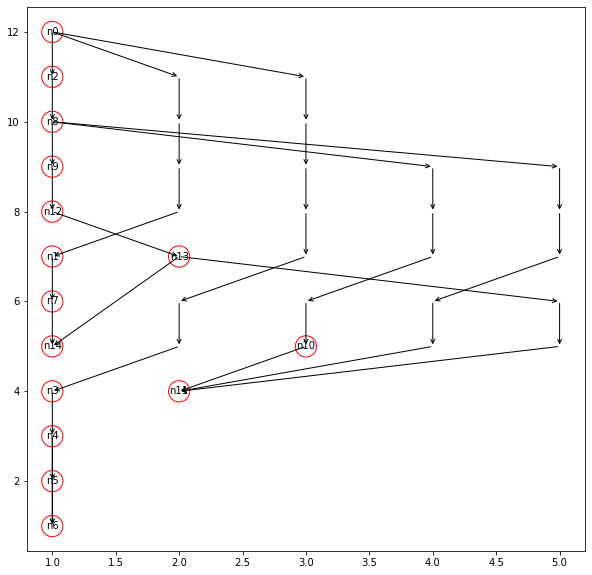

In [195]:
draw(G, cords, dummies)

Напишем функцию, для минимизации dummpy-вершин при отсутствии W


Для этого добавим очереди и linprog


In [196]:
from scipy.optimize import linprog
from queue import Queue

In [201]:
def min_dummy(G):
    rank = {}
    diff_l = []
    diff_r = []
    cnt_vertex = len(G.nodes)
    coef = cnt_vertex * [0]
    neighbors, neighbors_inv, cords, vert_order = first_step(G)

    for idx, node in enumerate(list(G.nodes)):
        rank[node] = idx

    for s, t in G.edges():
        diff_r.append(-1)
        coef[rank[s]] += 1
        coef[rank[t]] -= 1
        diff = [0] * cnt_vertex
        diff[rank[s]] = -1
        diff[rank[t]] = 1
        diff_l.append(diff)

    t = (1, float("inf"))
    bounds = [t] * cnt_vertex
    opt = linprog(c=coef, A_ub=diff_l, b_ub=diff_r, bounds=bounds, method="revised simplex")

    queue = Queue()
    for n, par in neighbors_inv.items():
        if len(par) == 0:
            cords[n] = (0, -1)
            queue.put(n)

    while not queue.empty():
        tmp_y = 0
        curr_v = queue.get()
        for p in neighbors_inv[curr_v]:
            tmp_y = max(tmp_y, cords[p][1] + 1)
        y_cord = min(int(opt.x[rank[curr_v]]), tmp_y)
        cords[curr_v] = (0, y_cord)
        for neighb in neighbors[curr_v]:
            if cords[neighb][1] != -1:
                queue.put(neighb)

    y_cords_list = []
    for coord in cords.values():
        y_cords_list.append(coord[1])

    max_y = max(y_cords_list)
    for node in cords:
        cords[node] = (0, max_y - cords[node][1] + 1)

    cords, dummies = change(G, cords)
    return G, cords, dummies

In [ ]:
Graph = nx.read_graphml('meth_viz/small_dag.graphml')
G, cords, dummies = min_dummy(Graph)


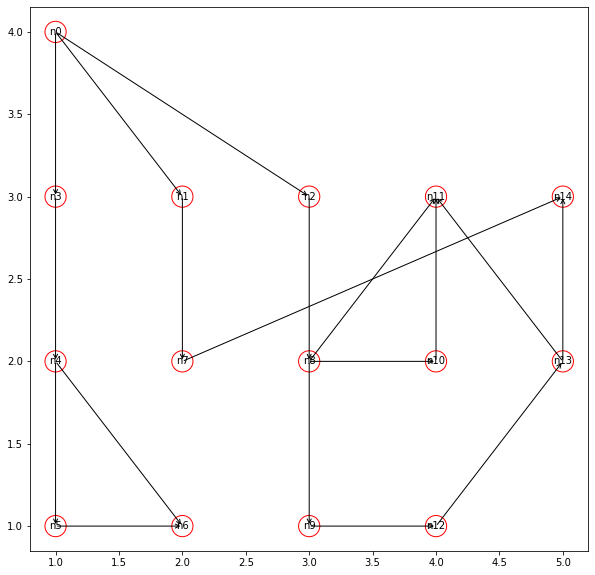

In [205]:
draw(G, cords, dummies)